In [1]:
!pip install evaluate transformers rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.1 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=357a5c70b8e3cb734ccb6d7a50661583787c2a84b586ab611a1e590bcbe09dad
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_syst

In [3]:
from datasets import load_dataset
from transformers import (
    BlipProcessor, 
    BlipForConditionalGeneration, 
    TrainingArguments, 
    Trainer
)
from peft import LoraConfig, get_peft_model
from evaluate import load
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

In [4]:
bleu_metric = load("bleu")
rouge_metric = load("rouge")

In [5]:
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    decoded_preds = processor.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    
    # BLEU avec différentes longueurs de n-grammes
    bleu_results = bleu_metric.compute(
        predictions=decoded_preds,
        references=[[label] for label in decoded_labels],
        max_order=4  # Pour BLEU-1 à BLEU-4
    )
    
    # ROUGE plus détaillé
    rouge_results = rouge_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )
    
    return {
        "bleu-1": bleu_results["precisions"][0],
        "bleu-4": bleu_results["bleu"],
        "rouge1": rouge_results["rouge1"].mid.fmeasure,
        "rougeL": rouge_results["rougeL"].mid.fmeasure
    }

In [7]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        caption = item["caption"]
        
        # Process image and text
        inputs = self.processor(
            images=image, 
            text=caption, 
            padding="max_length",
            return_tensors="pt",
            truncation=True
        )
        
        # Remove batch dimension and convert to correct types
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["labels"] = inputs["input_ids"]  # For BLIP, labels are same as input_ids
        
        return inputs

In [8]:
dataset = load_dataset("yemalin/furniture_ds")
dataset = dataset["train"].train_test_split(test_size=0.1, seed=42, shuffle=True)

README.md:   0%|          | 0.00/321 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/282M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14550 [00:00<?, ? examples/s]

In [9]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [10]:
train_dataset = ImageCaptioningDataset(dataset["train"], processor)
eval_dataset = ImageCaptioningDataset(dataset["test"], processor)

In [11]:
# LoRA configuration
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules=["query", "value", "key", "dense"]  # Simplified target modules
)

In [12]:
training_args = TrainingArguments(
    output_dir="./blip-afro-fashion",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=0.0001,
    fp16=True,
    logging_steps=250,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="none",
    label_names=["input_ids"],
    eval_strategy="no",
    logging_dir="./logs",
    save_strategy="epoch",                   # Enregistre à chaque époque
    save_total_limit=2,                      # Garde max 2 checkpoints
)

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

In [14]:
trainer.train()

Step,Training Loss
250,0.929200
500,0.059100
750,0.056200
1000,0.050900
1250,0.050400
1500,0.047800
1750,0.048000
2000,0.045000
2250,0.044900
2500,0.044900


TrainOutput(global_step=9819, training_loss=0.05636285822555895, metrics={'train_runtime': 8563.1774, 'train_samples_per_second': 4.588, 'train_steps_per_second': 1.147, 'total_flos': 2.3306120517485593e+19, 'train_loss': 0.05636285822555895, 'epoch': 2.999159984726995})

In [15]:
model.save_pretrained("./meublAI/model")

In [16]:
processor.save_pretrained("./meublAI/processor")

[]

In [23]:
!pip install -q huggingface_hub

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [24]:
from huggingface_hub import login

In [25]:
login()

In [35]:
model.eval()

for sample in dataset["test"].select(range(5)):  # Prendre quelques exemples
    image = sample["image"]
    caption = sample["caption"]

    inputs = processor(images=image, return_tensors="pt").to(model.device)
    output_ids = model.generate(**inputs, max_new_tokens=30)
    pred_caption = processor.decode(output_ids[0], skip_special_tokens=True)

    print(f"📷 Caption attendue : {caption}")
    print(f"🧠 Caption prédite : {pred_caption}")
    print("-" * 40)

📷 Caption attendue : Wooden armchair with a dark stained bamboo-style frame, beige upholstered cushion, and rolling casters.
🧠 Caption prédite : wooden armchair with a slatted backrest, curved armrests, and a beige upholstered seat.
----------------------------------------
📷 Caption attendue : Solid wood six-drawer chest with natural finish and metal pull handles.
🧠 Caption prédite : natural wood five - drawer chest with metal pull handles.
----------------------------------------
📷 Caption attendue : Gold-tone metal crib with vertical spindle sides and tall corner posts.
🧠 Caption prédite : gold - tone metal crib with vertical spindle railings and a white mattress.
----------------------------------------
📷 Caption attendue : Tufted brown velvet upholstered platform bed with a low-profile design and padded headboard.
🧠 Caption prédite : tufted brown velvet platform bed with a padded headboard.
----------------------------------------
📷 Caption attendue : Two-seater rattan sofa with or

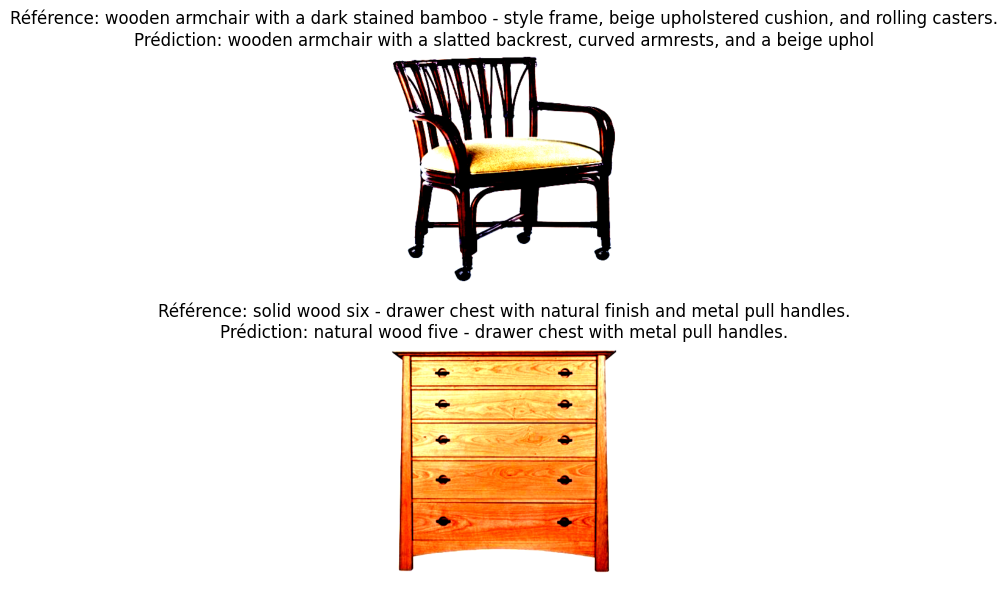

In [36]:
def visualize_predictions(model, dataset, num_samples=2):
    import matplotlib.pyplot as plt
    
    model.eval()
    samples = [dataset[i] for i in range(num_samples)]
    
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 3*num_samples))
    for idx, sample in enumerate(samples):
        image = sample["pixel_values"].unsqueeze(0).to(model.device)
        caption = processor.decode(sample["input_ids"], skip_special_tokens=True)
        
        # Génération
        output = model.generate(pixel_values=image)
        pred = processor.decode(output[0], skip_special_tokens=True)
        
        # Affichage
        axes[idx].imshow(sample["pixel_values"].permute(1, 2, 0).cpu().numpy())
        axes[idx].set_title(f"Référence: {caption}\nPrédiction: {pred}")
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Utilisation après l'entraînement
visualize_predictions(model, eval_dataset)

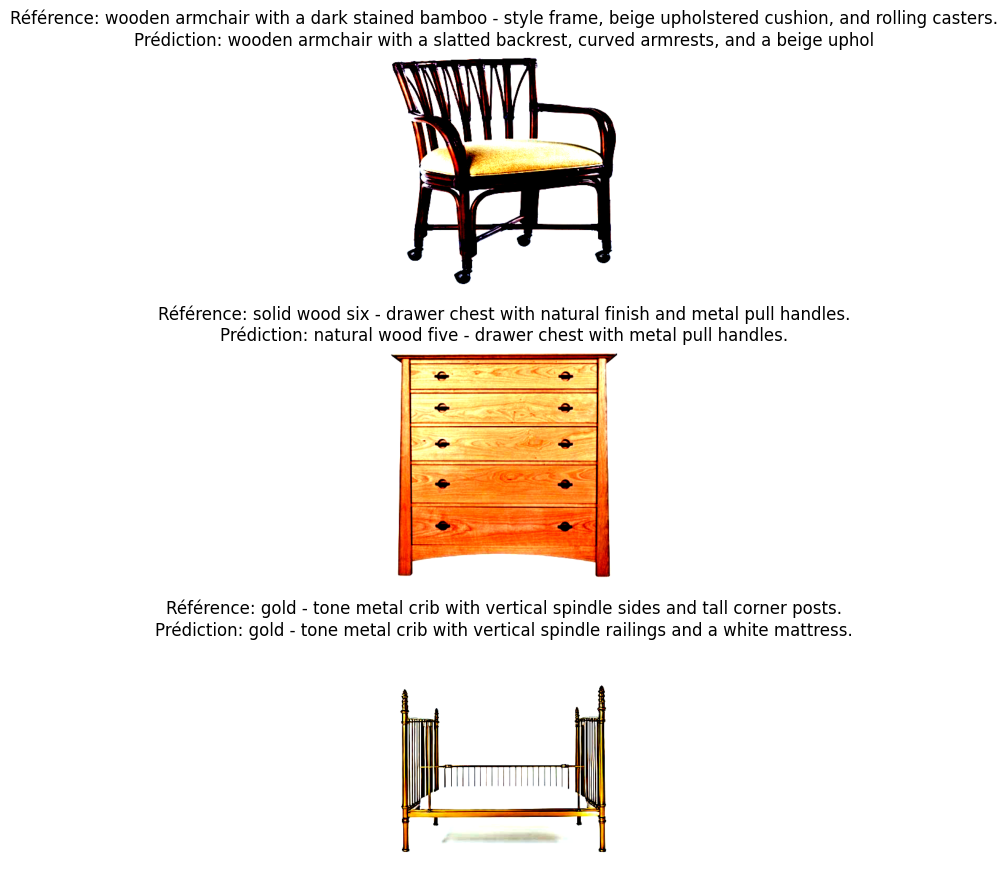

In [37]:
visualize_predictions(model, eval_dataset, 3)